In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
import os, sys
sys.path.append('../functions')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [4]:
data_0 = pandas.read_csv('Data/hits.csv', index_col=0)
data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [5]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=100, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

100


/Users/mikhail91/.virtualenvs/rep_6_6/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Tracks Reconstruction

In [6]:
from baseline import SimpleTemplateMatching
from fast_hough import FastHough
from retina import ArtificialRetina
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [7]:
event = data[data.EventID == 1339.0]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [8]:
#%%time
fh = ArtificialRetina(n_tracks=2, residuals_threshold=0.5, sigma=0.1, min_hits=2)
inds = fh.fit(x, y)

track_inds = fh.track_inds_
tracks_params = fh.tracks_params_

In [9]:
track_inds

array([array([28,  5, 18, 22, 13, 26,  7,  2, 30, 17]),
       array([29, 14, 16, 27, 33,  3,  1, 24])], dtype=object)

In [10]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, track_inds)

print hme.recognition_efficiency_
print hme.clone_rate_
print hme.ghost_rate_
print hme.avg_efficiency_

1.0
0.0
0.0
1.0


In [11]:
tracks_params

array([[  3.73176074e-02,   1.26224372e+02],
       [ -6.59189799e-04,   7.49548450e+01]])

In [12]:
event12.Label.values

array([ 0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.])

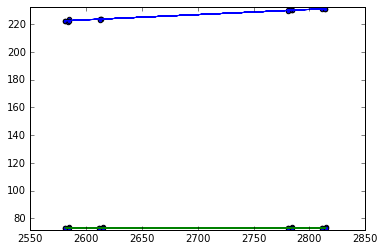

In [13]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
    
plt.ylim(y.min() - 1, y.max() + 1)
plt.show()

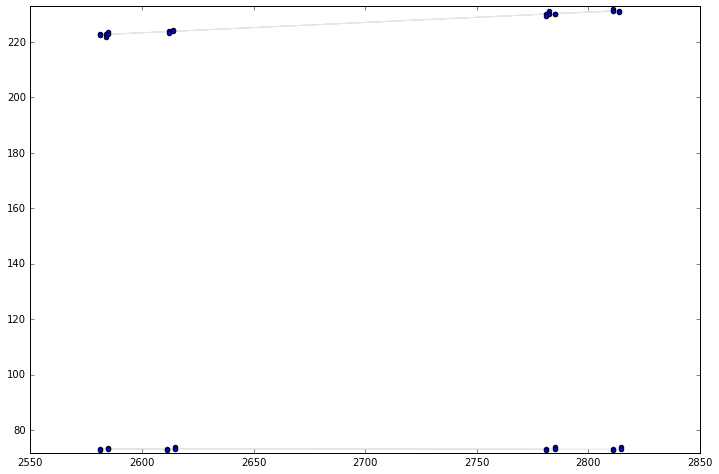

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y)

for track in track_inds:
    
    plt.plot(x[track], y[track], alpha=0.1, color='0')
    pass

plt.ylim(y.min()-1, y.max()+1)
plt.show()

# Train Classifier for the Tracks Combination

In [15]:
from baseline import SimpleTemplateMatching
from reconstruction import TracksReconstruction2D, TracksReconstruction2DPlus
from combination import Combinator, SuperCombinator
from retina import ArtificialRetina
from sklearn.linear_model import RANSACRegressor
from ransac import RANSACTracker


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tracks Reconstruction

In [16]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = event_ids_test
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    
    # Select model for the tracks reconstruction
    #stm_y = LinearHoughModel(k_params=(-0.35, 0.35, 2500), b_params=(-850, 850, 2500), n_candidates=2, show=False)
    #stm_stereo = LinearHoughModel(k_params=(-0.3, 0.3, 100), b_params=(-500, 500, 100), n_candidates=1, show=False)
    #stm_y = FastHough(n_tracks=2, min_hits=3, k_size=0.7/4000, b_size=1700./4000, k_limits=(-0.35, 0.35), b_limits=(-850, 850))
    #stm_stereo = FastHough(n_tracks=1, min_hits=3, k_size=0.6/160, b_size=1000./160, k_limits=(-0.3, 0.3), b_limits=(-500, 500))
    
    stm_y = ArtificialRetina(n_tracks=2, residuals_threshold=0.15, sigma=0.2, min_hits=2, 
                               k_size=0.7/10000,
                               b_size=1700./10000,
                               k_limits=(-0.5, 0.5),
                               b_limits=(-1150, 1150))
    stm_stereo = ArtificialRetina(n_tracks=1, residuals_threshold=2, sigma=2, min_hits=2, 
                                    k_size=0.6/200,
                                    b_size=1000./200,
                                    k_limits=(-0.3, 0.3),
                                    b_limits=(-500, 500))

    tr2d = TracksReconstruction2DPlus(model_y=stm_y, model_stereo=stm_stereo, y_tracks_preselection=False, unique_hit_labels=True)
    tr2d.fit(event, None)
    
    track_inds12, tracks_params12 = tr2d.track_inds12_, tr2d.tracks_params12_
    track_inds34, tracks_params34 = tr2d.track_inds34_, tr2d.tracks_params34_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'indeces12':track_inds12, 'params12':tracks_params12, 
                           'indeces34':track_inds34, 'params34':tracks_params34}
    
    return one_track

# if __name__ == "__main__":
#     p = Pool(3)
#     results = p.map(tracks_reconstruction, event_ids)
#     tracks = merge_dicts(results)

CPU times: user 434 µs, sys: 1.09 ms, total: 1.52 ms
Wall time: 1.71 ms


In [17]:
%%time
results = []
for i in event_ids:
    one_res = tracks_reconstruction(i)
    results.append(one_res)
tracks = merge_dicts(results)

CPU times: user 37.3 s, sys: 343 ms, total: 37.7 s
Wall time: 39.2 s


In [18]:
30 * 1000 / len(event_ids)

52

In [19]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    track_inds12 = tracks[event_id]['indeces12']
    tracks_params12 = tracks[event_id]['params12']
    track_inds34 = tracks[event_id]['indeces34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm12.fit(track_inds12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm34.fit(track_inds34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    #comb = SuperCombinator(classifier=folding.estimators[0])
    comb = Combinator()
    #comb = SuperCombinator(classifier=xgb_base)
    #comb = SuperCombinator(classifier=folding.estimators[0])
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(track_inds12, track_inds34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 22.5 s, sys: 136 ms, total: 22.6 s
Wall time: 23 s


# Quality

# Stations 1&2

### Y-views

In [20]:
tracks_metrics_before_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.998192
RecoEff         0.999123
GhostRate       0.000000
CloneRate       0.000877
dtype: float64

### Stereo-views

In [21]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.997078
RecoEff         0.998246
GhostRate       0.000000
CloneRate       0.001754
dtype: float64

### Stations 1&2

In [22]:
tracks_metrics_before_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.997321
RecoEff         0.999123
GhostRate       0.000000
CloneRate       0.000877
dtype: float64

### Track efficiency

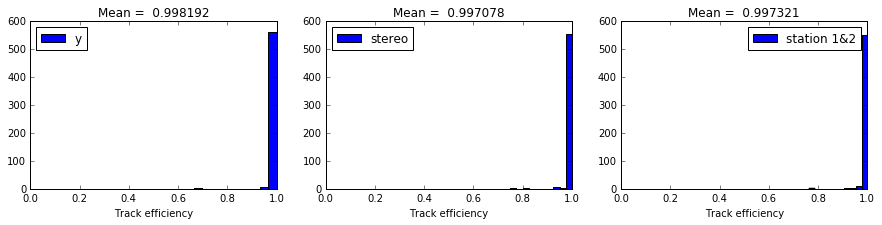

In [23]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

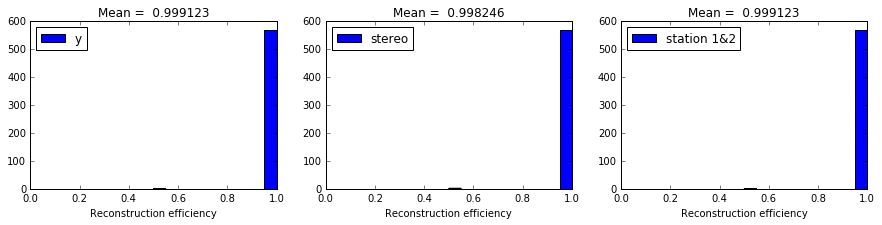

In [24]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [25]:
tracks_metrics_after_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.998779
RecoEff         0.993860
GhostRate       0.000877
CloneRate       0.005263
dtype: float64

### Stereo-views

In [26]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.999271
RecoEff         0.993860
GhostRate       0.000877
CloneRate       0.005263
dtype: float64

### Station 3&4

In [27]:
tracks_metrics_after_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.999043
RecoEff         0.993860
GhostRate       0.000877
CloneRate       0.005263
dtype: float64

### Tracks efficiency

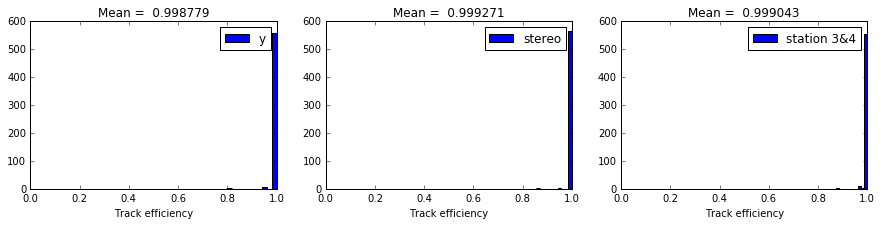

In [28]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

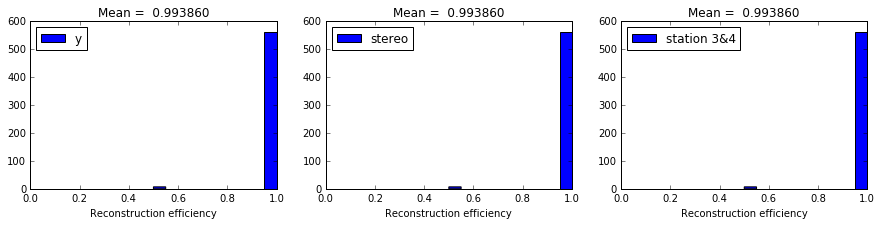

In [29]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [30]:
combinations_quality.mean(axis=0)

EventID      2567.573684
RecoEff         0.991228
GhostRate       0.001754
CloneRate       0.003509
NCombined       1.989474
dtype: float64

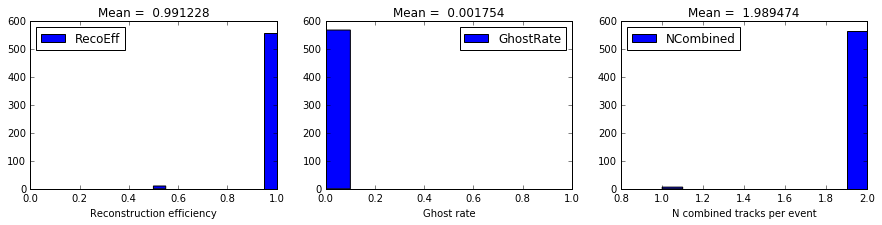

In [31]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
#plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
#plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

In [32]:
combinations_quality.head(5)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4097,1,0,0,2
1,2,1,0,0,2
2,3243,1,0,0,2
3,3081,1,0,0,2
4,10,1,0,0,2


# Ratio of the events passes through the stages

98.2456140351


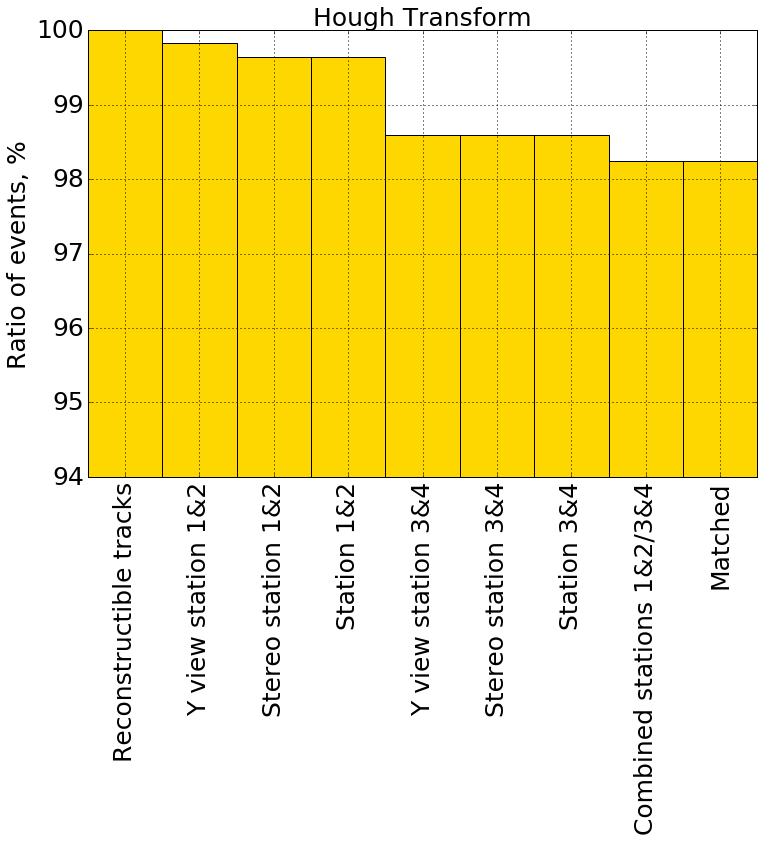

In [33]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(12,8))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.5, 8.5)
plt.ylim(94, 100)
#plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=25)
plt.grid(linewidth=1)
plt.title('Hough Transform', size=25)
plt.show()

In [34]:
bar_values

array([ 100.        ,   99.8245614 ,   99.64912281,   99.64912281,
         98.59649123,   98.59649123,   98.59649123,   98.24561404,
         98.24561404])

In [35]:
#event_ids = numpy.unique(data.EventID.values)

def TotalEffVsTrackEff(event_ids, track_eff_cuts):

    total_efficiencies = []
    momentum_mae = []

    for cut in track_eff_cuts:

        combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                         'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

        pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                                'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

        for event_id in event_ids:

            # Get an event
            event = data[data.EventID == event_id]
            event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
            event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]


            track_inds12 = tracks[event_id]['indeces12']
            tracks_params12 = tracks[event_id]['params12']
            track_inds34 = tracks[event_id]['indeces34']
            tracks_params34 = tracks[event_id]['params34']

            # Quality metrics of the reconstruction
            trm12 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm12.fit(track_inds12, event12)

            # Quality metrics of the reconstruction
            trm34 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm34.fit(track_inds34, event34)

            # Combination of the tracks before and after the magnet
            #comb = SuperCombinator(classifier=folding.estimators[0])
            comb = Combinator()
            comb.combine(tracks_params12, tracks_params34)


            # Quality of the combination
            cq = CombinatorQuality()
            cq.fit(track_inds12, track_inds34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)



            # Overall quality
            line = numpy.array([1, 
                                 (trm12.recognition_efficiency_y_ == 1)*1, 
                                 (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm12.recognition_efficiency_ == 1)*1,
                                 (trm34.recognition_efficiency_y_ == 1)*1, 
                                 (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm34.recognition_efficiency_ == 1)*1, 
                                 (cq.n_combined_ >= 2)*1,
                                 (cq.reco_eff_ == 1)*1]).cumprod()
            pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)

        bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
        bar_values = bar_values / bar_values[0] * 100

        total_eff = bar_values[-1]
        total_efficiencies.append(total_eff)

    total_efficiencies = numpy.array(total_efficiencies)

    return total_efficiencies

In [36]:
%%time
# track_eff_cuts = numpy.linspace(0, 1., 11)
# total_efficiencies = TotalEffVsTrackEff(event_ids, track_eff_cuts)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [37]:
# plt.figure(figsize=(12, 8))
# l = 'max = ' + str(numpy.round(total_efficiencies[0], 1)) + '%, ' + 'min = ' + str(numpy.round(total_efficiencies[-1], 1)) + '%'
# plt.plot(track_eff_cuts*100, total_efficiencies, linewidth=5, label=l)
# plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
# plt.title("Hough Transform", fontsize=25)
# plt.xlabel('Track Efficiency Threshold, %', fontsize=25)
# plt.ylabel('Total Reconstruction Efficiency, %', fontsize=25)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.ylim(80, 100)
# plt.xlim(0., 100.)
# plt.grid(linewidth=1)
# plt.show()

# Momentum

In [38]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

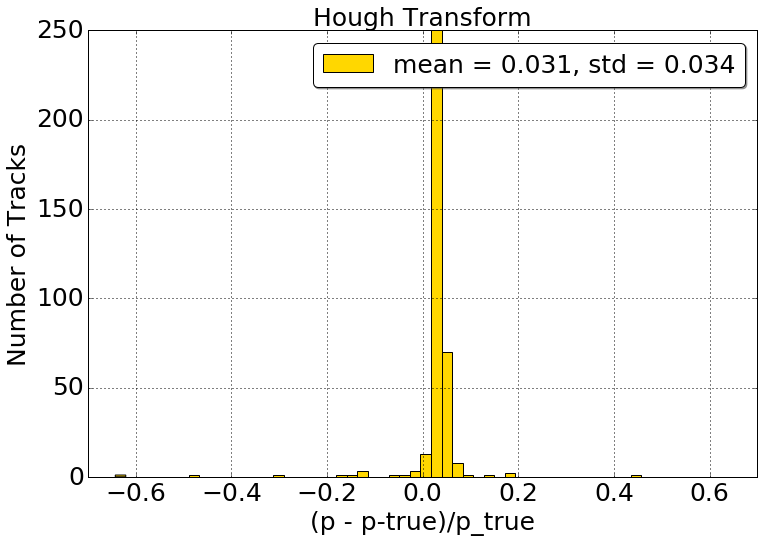

In [39]:
plt.figure(figsize=(12, 8))
q = -p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
l = 'mean = ' + str(numpy.round(q.mean(), 3)) + ', std = ' + str(numpy.round(q.std(), 3))
plt.hist(q, bins=50, normed=False, label=l, color='gold')
#plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('Hough Transform', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
#plt.title("TrackEff vs RecoEff", fontsize=25)
plt.xlabel('(p - p-true)/p_true', fontsize=25)
plt.ylabel('Number of Tracks', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 250)
plt.xlim(-0.7, 0.7)
plt.grid(linewidth=1)
plt.show()

In [40]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

2

In [41]:
print numpy.abs(p_err[numpy.isfinite(p_err)]).mean() * 100

3.62764165453


# Did not recognized tracks

In [42]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
81,143,1,1,1,1,0,0,0,0,0
146,4342,1,1,1,1,1,1,1,0,0
160,270,1,1,1,1,0,0,0,0,0
227,3781,1,1,1,1,0,0,0,0,0
230,4490,1,1,1,1,0,0,0,0,0
330,3654,1,1,0,0,0,0,0,0,0
392,1722,1,1,1,1,0,0,0,0,0
489,3942,1,1,1,1,1,1,1,0,0
546,1528,1,1,1,1,0,0,0,0,0
565,2040,1,0,0,0,0,0,0,0,0


In [43]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

143.0


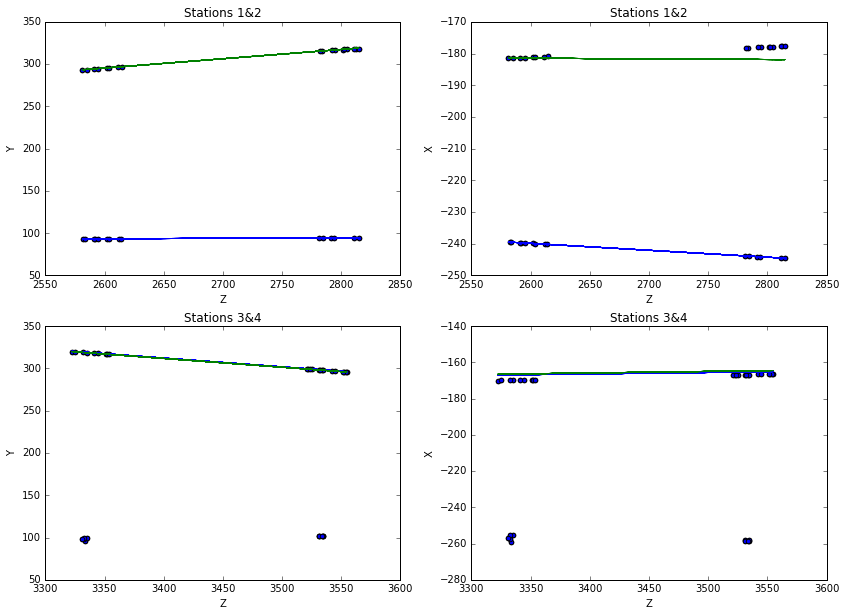

4342.0


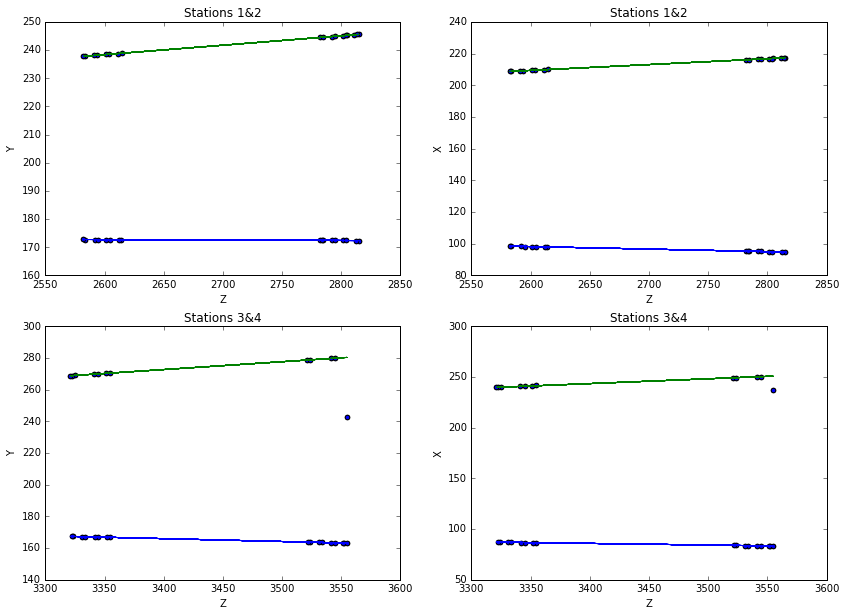

270.0


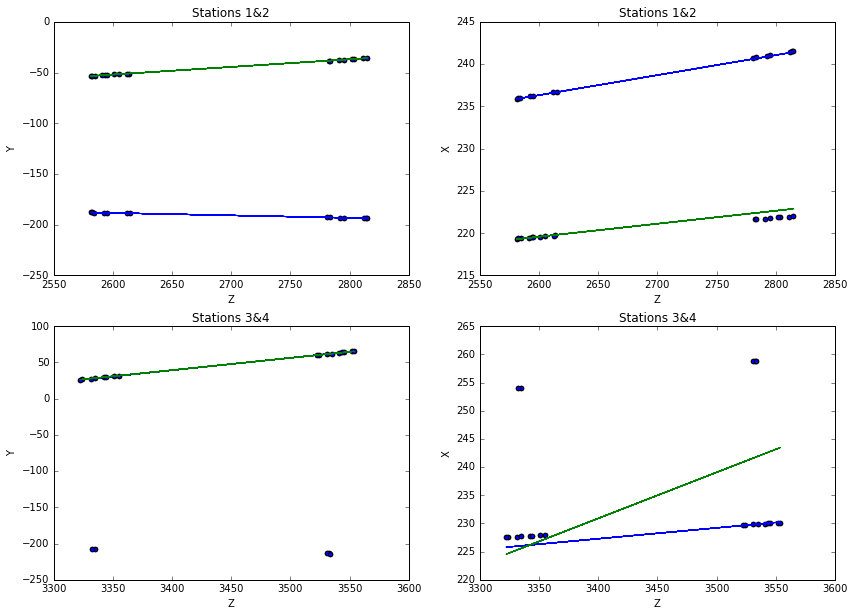

3781.0


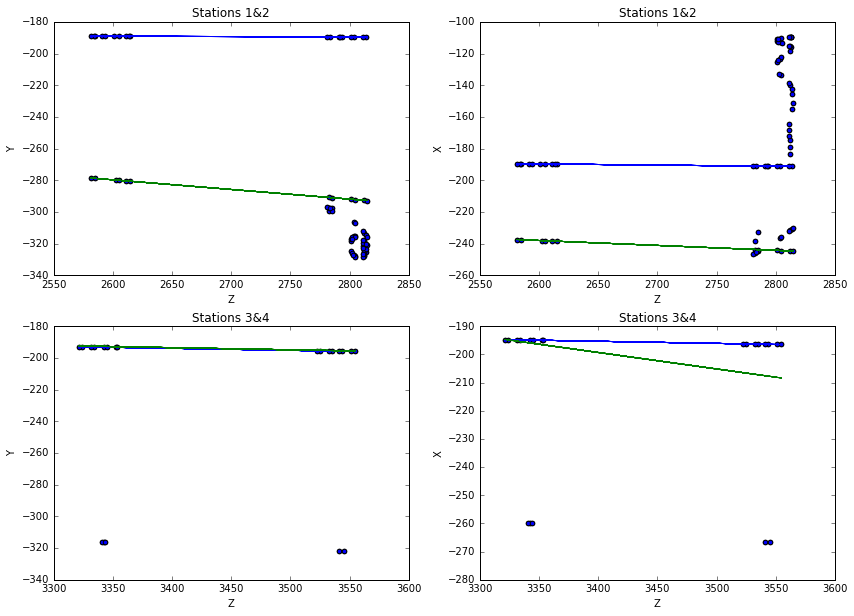

4490.0


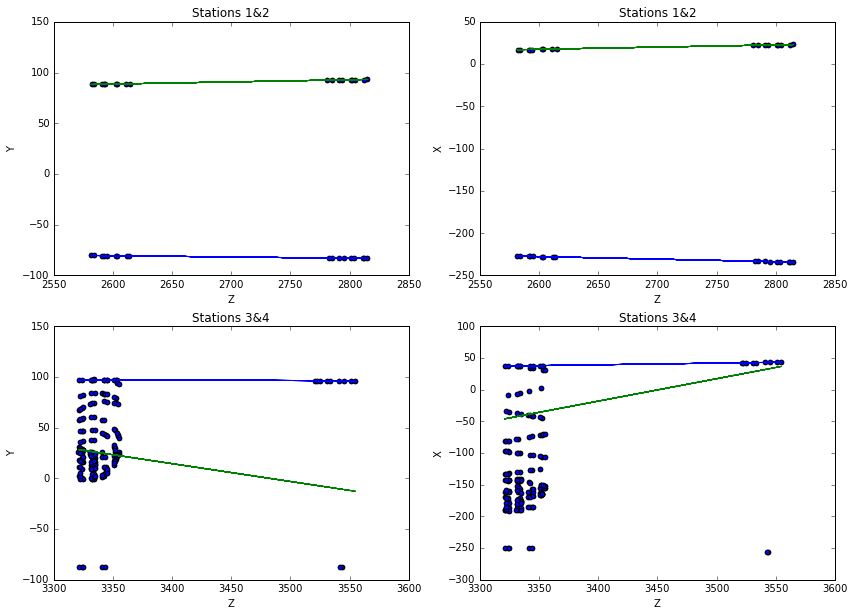

3654.0


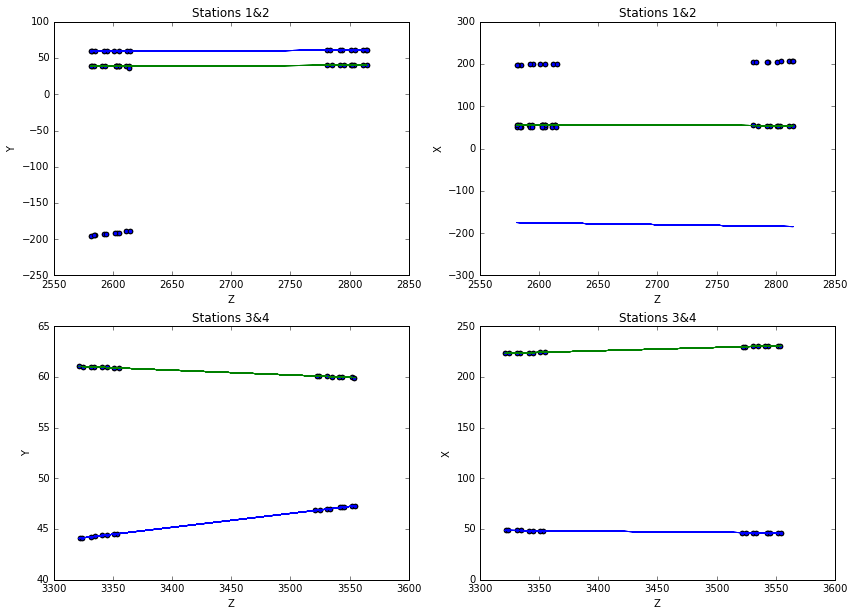

1722.0


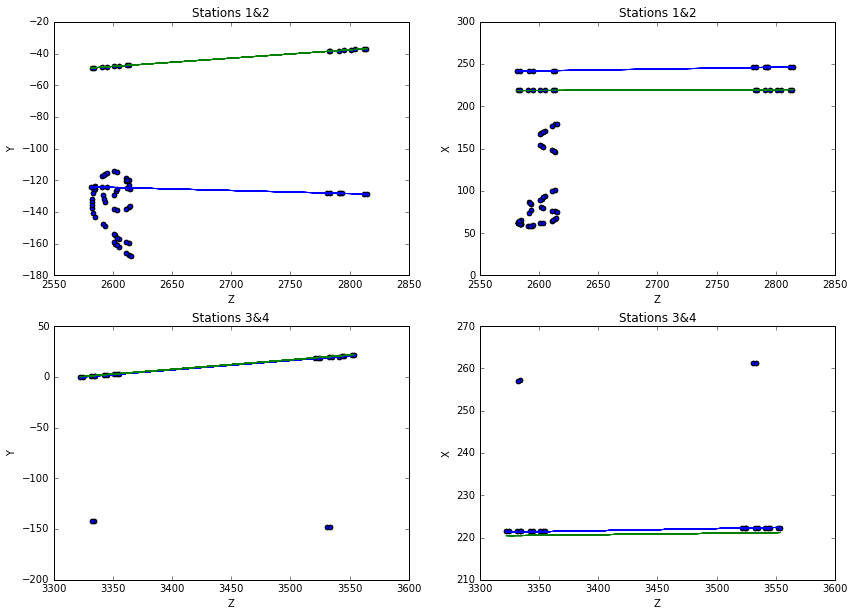

3942.0


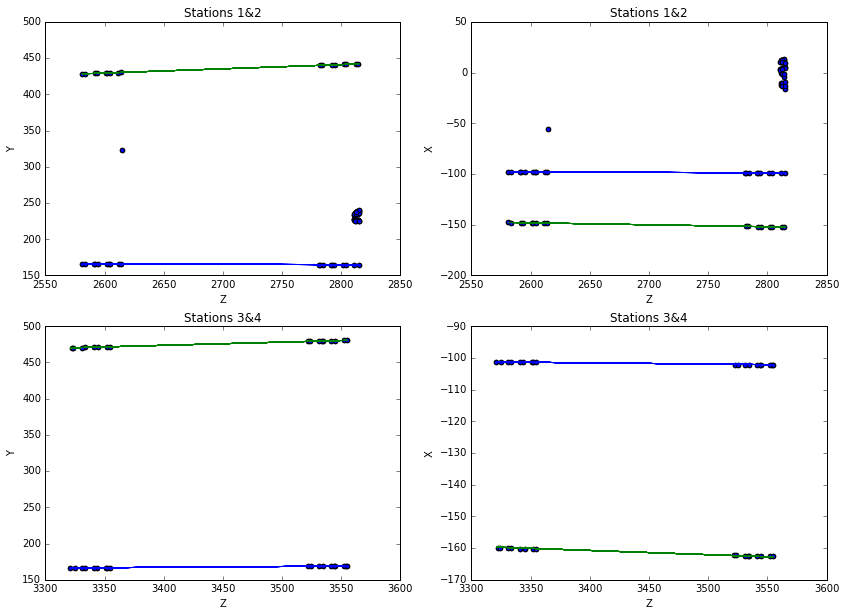

1528.0


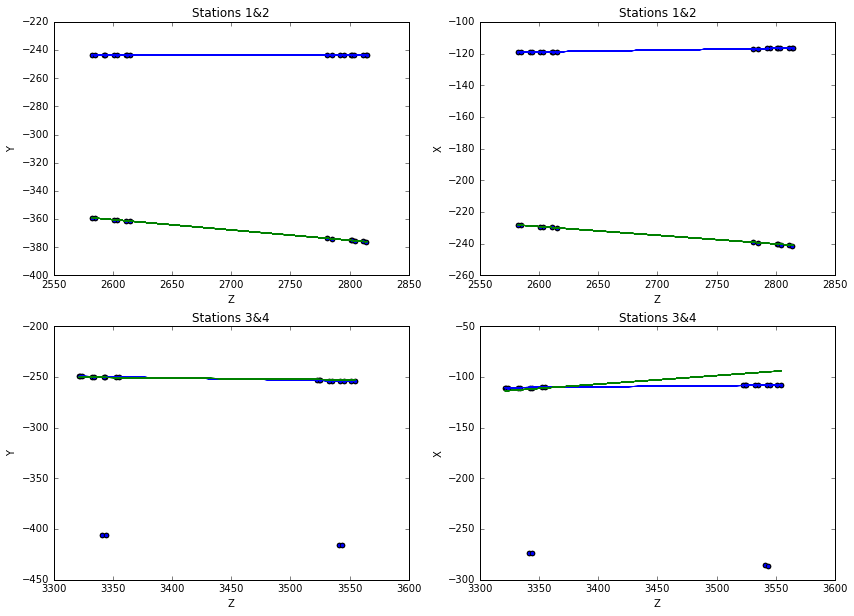

2040.0


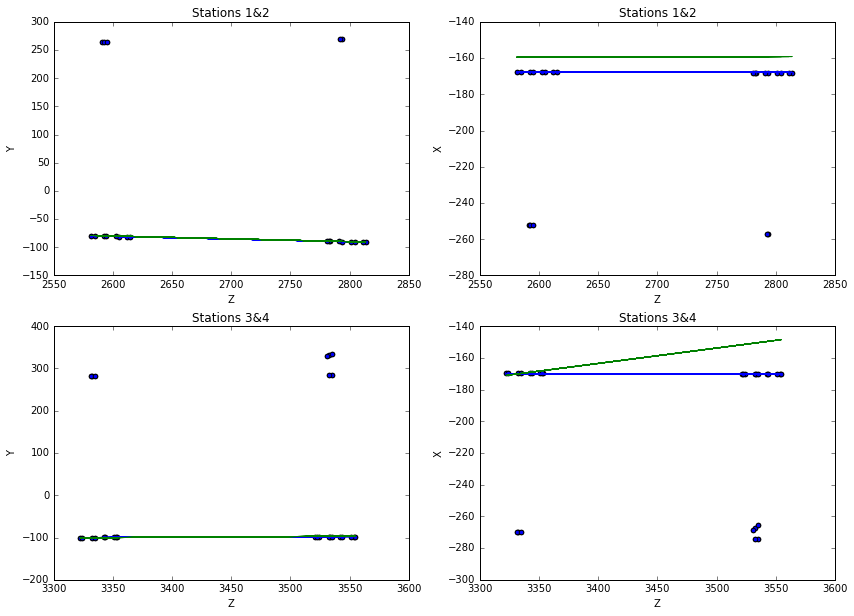

In [44]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)